### pcQTLs improve interpretability of eQTLs shared by multiple genes and identify causal variants with smaller credible sets

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import upsetplot as up
import ast
from scipy.stats import ttest_rel, ranksums

from tqdm.auto import tqdm 
tqdm.pandas()

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

a) all multi-gene eQTLs are pcQTLs (number e genes colored by if tagged by pcqtl)

In [6]:
# takes ~ 1:45
underlying_signals = load_across_tissues(config, load_signal_groups)
underlying_signals = remove_cross_map(underlying_signals, config=config)

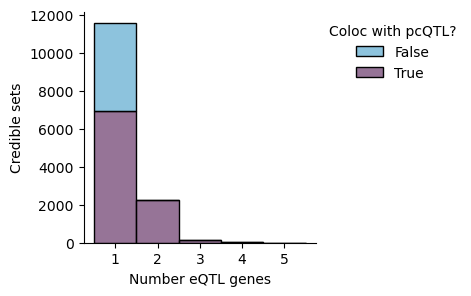

In [187]:
underlying_signals['pcQTL'] = underlying_signals['num_pc_coloc']>0

fig, ax = plt.subplots(figsize=(3,3))
sns.histplot(underlying_signals[(underlying_signals['num_e_coloc'] > 0)], x='num_e_coloc', hue='pcQTL', 
             multiple='stack', bins=range(1,7), palette={False:'#67AFD2', True:'#734675'},)

ax.set_xlabel('Number eQTL genes')
ax.set_ylabel('Credible sets')


# Change legend title
leg = ax.get_legend()
leg.set_title('Coloc with pcQTL?')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

ax.set_xticks([1.5,2.5,3.5,4.5, 5.5], [1,2,3,4, 5])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

b) multi-gene vs single-gene eQTLs are enriched for regulatory regions


In [10]:
# enrichment to 
susie_annotated = load_across_tissues(config, load_susie_annotated)

In [ ]:
# break out by gene id so I can match vep effects to genes in the cluster
susie_annotated['gene_id'] = susie_annotated['cluster_id'].str.split('_')
susie_annotated_explode = susie_annotated.explode('gene_id')

def get_gene_matched_effect(row):
    gene_matched_effect = []
    for vep_effect in row['vep_info'].split(','):
        if row['gene_id'].split('.')[0] in vep_effect:
            gene_matched_effect.append(vep_effect.split('|')[1])
    return list(set(gene_matched_effect))

susie_annotated_explode['vep_info_gene'] = susie_annotated_explode.progress_apply(get_gene_matched_effect, axis=1).astype(str)
# if nmd of a gene
susie_annotated_explode['vep_gene_matched_nmd'] = susie_annotated_explode['vep_info_gene'].str.contains('NMD_transcript_variant')
# if in an exon
susie_annotated_explode['vep_gene_matched_exon'] = susie_annotated_explode['vep_info_gene'].str.contains('missense_variant|synonymous_variant|NMD_transcript_variant|exon_variant', regex=True)
# in in any part of the gene
susie_annotated_explode['vep_gene_matched_intron'] = susie_annotated_explode['vep_info_gene'].str.contains('UTR_variant|intron_variant|splice_region_variant|splice_polypyrimidine_tract_variant', regex=True)
# if near the gene in any way
susie_annotated_explode['vep_gene_matched_neargene'] = susie_annotated_explode['vep_info_gene'].str.contains('downstream_gene_variant|upstream_gene_variant', regex=True)
# any effect on the transcript
susie_annotated_explode['vep_any_effect'] = susie_annotated_explode['vep_info_gene'].str.strip("'[],").apply(len) > 0
# vep related but not gene specific
susie_annotated_explode['vep_open_chrom'] = susie_annotated_explode['vep_info'].str.contains('open_chromatin_region')
susie_annotated_explode['vep_reg'] = susie_annotated_explode['vep_info'].str.contains('regulatory_region_variant')
susie_annotated_explode['vep_enhancer'] = susie_annotated_explode['vep_info'].str.contains('enhancer')
susie_annotated_explode['vep_promoter'] = susie_annotated_explode['vep_info'].str.contains('promoter')
susie_annotated_explode['vep_CTCF'] = susie_annotated_explode['vep_info'].str.contains('CTCF_binding_site')

  0%|          | 0/2507495 [00:00<?, ?it/s]

In [ ]:
# weight each varaint by its pip
col_names = ['vep_gene_matched_nmd', 'vep_gene_matched_exon', 'vep_gene_matched_intron', 'vep_gene_matched_neargene', 'vep_any_effect', 'in_shared_promoter', 'qtl_in_tad', 'between_tss', 'vep_open_chrom', 'vep_reg', 'vep_enhancer', 'vep_promoter', 'vep_CTCF']
pip_weighted_col_names = []
for col in col_names:
    pip_weighted_col_names.append(f'pip_{col}')
    susie_annotated_explode[f'pip_{col}'] = susie_annotated_explode[col] * susie_annotated_explode['pip']
pip_agg_dict = dict([(col, 'sum') for col in pip_weighted_col_names])
# group over credible sets, summing over the pip weighted values
cs_grouped_gene_split = susie_annotated_explode.groupby(['cs_id', 'gene_id', 'tissue_id', 'phenotype_id', 'cluster_id']).agg(pip_agg_dict)
# group over egenes
cs_grouped = cs_grouped_gene_split.groupby(['cs_id', 'tissue_id', 'phenotype_id', 'cluster_id']).agg(dict([(col, ['max', 'min', 'mean']) for col in pip_weighted_col_names])).reset_index()

# add some descriptive columns
cs_grouped['pc_num'] = np.where(cs_grouped['phenotype_id'].str.contains('_pc'), cs_grouped['phenotype_id'].str.split('_pc').str[-1], 0).astype(int)
cs_grouped['cluster_size'] = cs_grouped['cluster_id'].str.split('_').apply(len)
# fix column labels
cs_grouped.columns = cs_grouped.columns.map(lambda x: '_'.join(x).rstrip('_')) 

# combine into signal groups
underlying_signals['cs_id'] = underlying_signals['signal_id'].str.split('-')
underlying_signals_explode = pd.merge(underlying_signals.explode('cs_id'), cs_grouped, on=['cs_id', 'tissue_id'], how='inner')
underlying_signals_explode['vep_effect_only_1_gene'] = (underlying_signals_explode['pip_vep_any_effect_max'] == underlying_signals_explode['pip_vep_any_effect_mean']*underlying_signals_explode['cluster_size']) & (underlying_signals_explode['pip_vep_any_effect_max']>0)

pip_vep_gene_matched_nmd_max
Optimization terminated successfully.
         Current function value: 0.416934
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                32219
Model:                          Logit   Df Residuals:                    32216
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Dec 2024   Pseudo R-squ.:               0.0006056
Time:                        16:00:26   Log-Likelihood:                -13433.
converged:                       True   LL-Null:                       -13441.
Covariance Type:            nonrobust   LLR p-value:                 0.0002915
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            1.8477    

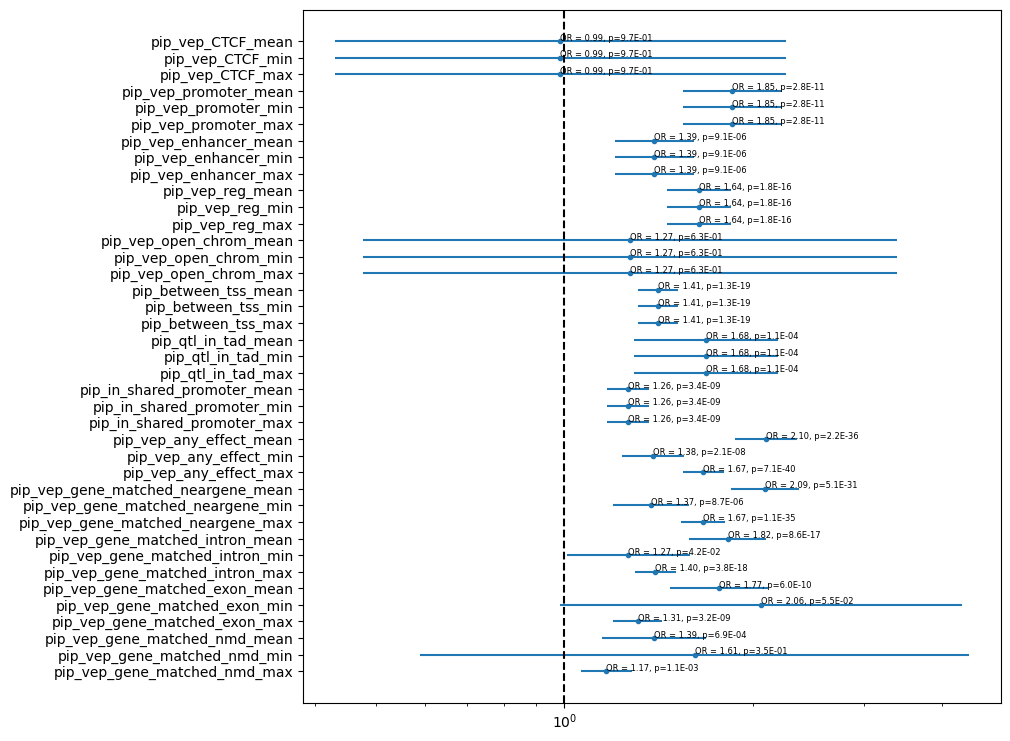

In [190]:
ax = make_log_odds_plot_multiple([get_odds_df(underlying_signals_explode, label_col='pcQTL', column_list=cs_grouped.columns[4:-3], correct_on=True, correct_on_column='cluster_size')])


In [ ]:
# pull out specific columns
# pull out specific columns

final_plot_columns = ['pip_vep_promoter_mean', 'pip_in_shared_promoter_mean', 'pip_vep_enhancer_mean', 'pip_vep_CTCF_mean', 'pip_qtl_in_tad_mean', 'pip_vep_any_effect_min', 'vep_effect_only_1_gene']
or_multigene = get_odds_df(underlying_signals_explode[underlying_signals_explode['num_e_coloc']>0], label_col='multiple_e', column_list=final_plot_columns[::-1], correct_on=True, correct_on_column='cluster_size')
or_multigene.reset_index(inplace=True)

vep_effect_only_1_gene
Optimization terminated successfully.
         Current function value: 0.588878
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                28218
Model:                          Logit   Df Residuals:                    28215
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Dec 2024   Pseudo R-squ.:                0.009598
Time:                        15:49:18   Log-Likelihood:                -16617.
converged:                       True   LL-Null:                       -16778.
Covariance Type:            nonrobust   LLR p-value:                 1.161e-70
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.4010      0.049    -28.326      

/local/scratch/klawren/slrmtmp.47304989/ipykernel_62763/4243830494.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['In promoter', 'In shared promoter', 'In enhancer', 'In CTCF site', 'In TAD boundry', 'VEP effect on all genes', 'VEP effect on only 1 gene'][::-1])


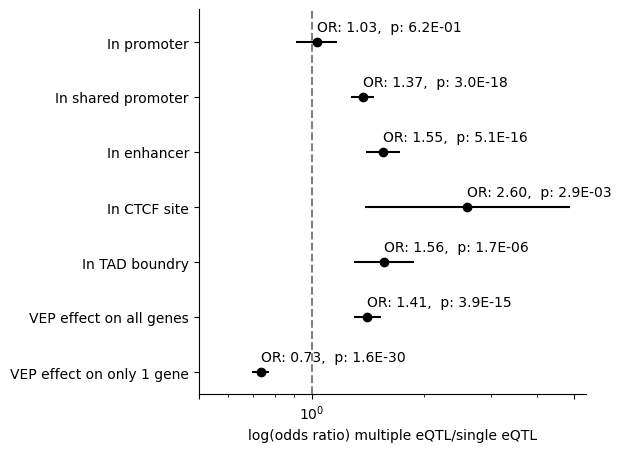

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.errorbar(y=or_multigene['col'], x=or_multigene['odds_ratio'], xerr=np.clip(or_multigene[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), -3, 3), fmt="o", color='k')
# add line at 0
ax.axvline(1, color='grey', linestyle='--')
# add annotations
for idx, row in or_multigene.iterrows():
    ax.annotate('OR: {:.2f},  p: {:.1E}'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.2))

# give some more space on the y axis
ax.set_ylim((ax.get_ylim()[0]-.1, ax.get_ylim()[1]+.3))
ax.set_yticklabels(['In promoter', 'In shared promoter', 'In enhancer', 'In CTCF site', 'In TAD boundry', 'VEP effect on all genes', 'VEP effect on only 1 gene'][::-1])

# format the x axis
ax.set_xlabel('log(odds ratio) multiple eQTL/single eQTL')
ax.set_xscale('log')
ax.set_xticks([.5, 1, 5])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [204]:
#TODO, given vep effect, vep effect on multipl genes?

In [188]:
underlying_signals_explode

,signal_id,num_e_coloc,num_pc_coloc,multiple_e,multiple_pc,cluster_id_x,lead_var_set,var_set,tissue_id,pcQTL,...,pip_vep_promoter_max,pip_vep_promoter_min,pip_vep_promoter_mean,pip_vep_CTCF_max,pip_vep_CTCF_min,pip_vep_CTCF_mean,pc_num,pcqtl,cluster_size,vep_effect_only_1_gene
0,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,1,1,False,False,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,"[chr1_52919105_G_A_b38, chr1_52806130_G_A_b38]","[chr1_52944792_T_C_b38, chr1_52739894_C_T_b38,...",Adipose_Subcutaneous,True,...,0.000000,0.000000,0.000000,0.075655,0.075655,0.075655,0,False,4,False
1,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,1,1,False,False,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,"[chr1_52919105_G_A_b38, chr1_52806130_G_A_b38]","[chr1_52944792_T_C_b38, chr1_52739894_C_T_b38,...",Adipose_Subcutaneous,True,...,0.000000,0.000000,0.000000,0.006793,0.006793,0.006793,2,True,4,False
2,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,1,1,False,False,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,[chr1_53088633_G_A_b38],[chr1_53088633_G_A_b38],Adipose_Subcutaneous,True,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,False,4,False
3,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,1,1,False,False,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,[chr1_53088633_G_A_b38],[chr1_53088633_G_A_b38],Adipose_Subcutaneous,True,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,True,4,False
4,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...,2,1,True,False,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...,"[chr1_46819478_G_A_b38, chr1_46811545_C_T_b38]","[chr1_46817216_C_T_b38, chr1_46819478_G_A_b38,...",Adipose_Subcutaneous,True,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,False,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32214,ENSG00000173083.14_ENSG00000173085.13_pc2_cs_2,0,1,False,False,ENSG00000173083.14_ENSG00000173085.13,[chr4_83215284_C_T_b38],"[chr4_83232120_G_A_b38, chr4_83240369_C_T_b38,...",Whole_Blood,True,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,True,2,False
32215,ENSG00000160299.16_ENSG00000160305.17_ENSG0000...,0,1,False,False,ENSG00000160299.16_ENSG00000160305.17_ENSG0000...,[chr21_46604713_G_A_b38],"[chr21_46587274_T_TA_b38, chr21_46618514_A_G_b...",Whole_Blood,True,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,True,3,False
32216,ENSG00000149131.15_ENSG00000156587.15_e_ENSG00...,1,0,False,False,ENSG00000149131.15_ENSG00000156587.15,[chr11_57601535_C_G_b38],"[chr11_57729348_C_T_b38, chr11_57779528_T_C_b3...",Whole_Blood,False,...,0.018634,0.018634,0.018634,0.006535,0.006535,0.006535,0,False,2,True
32217,ENSG00000167261.13_ENSG00000167264.17_pc1_cs_2,0,1,False,False,ENSG00000167261.13_ENSG00000167264.17,[chr16_68103517_C_G_b38],"[chr16_67998971_A_C_b38, chr16_68011821_C_T_b3...",Whole_Blood,True,...,0.208547,0.208547,0.208547,0.000000,0.000000,0.000000,1,True,2,False


In [203]:
underlying_signals_explode.groupby('exclusive_label').agg({x:'mean' for x in final_plot_columns})

,pip_vep_promoter_mean,pip_in_shared_promoter_mean,pip_vep_enhancer_mean,pip_vep_CTCF_mean,pip_qtl_in_tad_mean,pip_vep_any_effect_min,vep_effect_only_1_gene
exclusive_label,,,,,,,
eqtl_only,0.049480,0.686868,0.094205,0.002929,0.026538,0.129307,0.407525
pcqtl_only,0.039544,0.669041,0.076152,0.001933,0.031767,0.121436,0.376406
shared,0.076138,0.730526,0.116250,0.003068,0.035392,0.162592,0.441734


In [196]:
underlying_signals_explode['pcqtl_bool'] = underlying_signals_explode['num_pc_coloc'] > 0
underlying_signals_explode['pcqtl_only_bool'] = underlying_signals_explode['num_e_coloc'] == 0
underlying_signals_explode['exclusive_label'] = np.where((underlying_signals_explode['num_e_coloc'] > 0), np.where((underlying_signals_explode['num_pc_coloc'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')


vep_effect_only_1_gene
Optimization terminated successfully.
         Current function value: 0.588878
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                28218
Model:                          Logit   Df Residuals:                    28215
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Dec 2024   Pseudo R-squ.:                0.009598
Time:                        16:03:16   Log-Likelihood:                -16617.
converged:                       True   LL-Null:                       -16778.
Covariance Type:            nonrobust   LLR p-value:                 1.161e-70
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.4010      0.049    -28.326      

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4731
Model:                          Logit   Df Residuals:                     4728
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Dec 2024   Pseudo R-squ.:                     inf
Time:                        16:03:20   Log-Likelihood:            -3.1481e-07
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -26.9453   4449.231     -0.006      0.995   -8747.278    8693.387
cluster_size          1.1746    882.954     

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4731
Model:                          Logit   Df Residuals:                     4728
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Dec 2024   Pseudo R-squ.:                     inf
Time:                        16:03:20   Log-Likelihood:            -1.0092e-10
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -28.4776   1.61e+06  -1.76e-05      1.000   -3.16e+06    3.16e+06
cluster_size                   -2.3004   7.76e+05  -2.97e-06      1.000   -1.52e

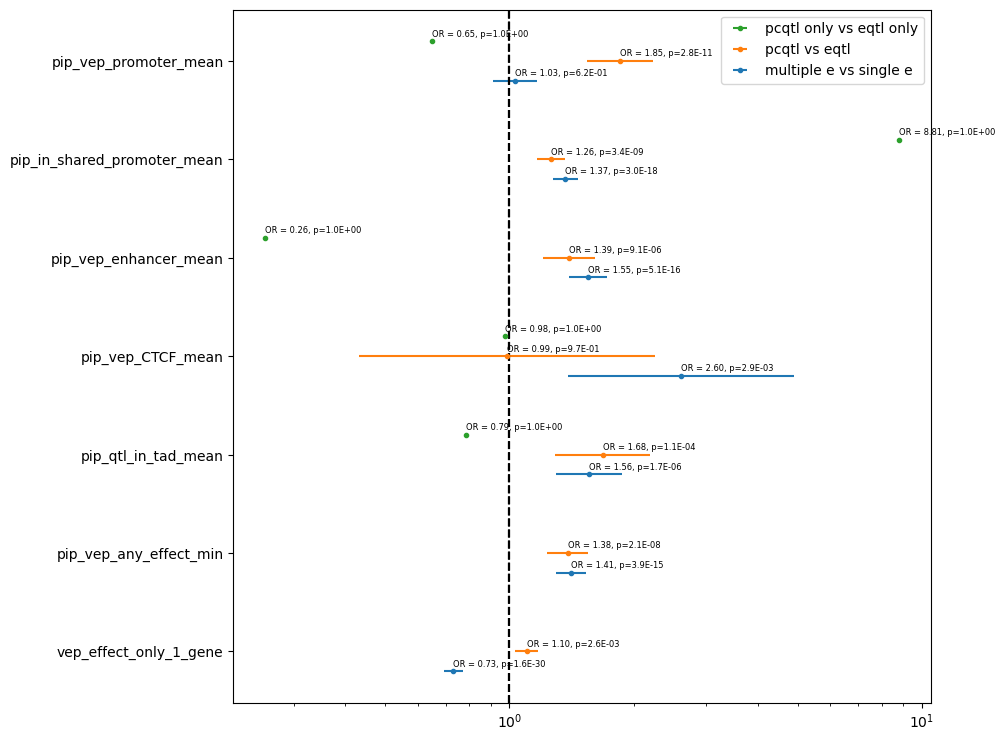

In [197]:
ax = make_log_odds_plot_multiple([get_odds_df(underlying_signals_explode[underlying_signals_explode['num_e_coloc']>0], label_col='multiple_e', column_list=final_plot_columns[::-1], correct_on=True, correct_on_column='cluster_size'),
                                  get_odds_df(underlying_signals_explode, label_col='pcqtl_bool', column_list=final_plot_columns[::-1], correct_on=True, correct_on_column='cluster_size'), 
                                  get_odds_df(underlying_signals_explode[underlying_signals_explode['exclusive_label'].isin(['pqtl_only', 'eqtl_only'])], label_col='pcqtl_only_bool', column_list=final_plot_columns[::-1], correct_on=True, correct_on_column='cluster_size')], 
                                labels=['multiple e vs single e', 'pcqtl vs eqtl', 'pcqtl only vs eqtl only'])


c) smaller credible sets sizes for pcQTLs

In [210]:
multigene_signals = underlying_signals[underlying_signals['num_e_coloc']>1]

In [217]:
# Create a mapping of cs_id and tissue_id to their corresponding counts
count_map = susie_annotated.groupby(['cs_id', 'tissue_id']).size().reset_index(name='count')

def get_cs_sizes(row):
    pc_cs_sizes = []
    e_cs_sizes = []
    # Iterate over each cs_id present in the row
    for cs_id in row['cs_id']:
        # Match corresponding counts from count_map
        match = count_map[(count_map['cs_id'] == cs_id) & (count_map['tissue_id'] == row['tissue_id'])]
        if not match.empty:
            cs_size = match['count'].values[0]
            if '_pc' in cs_id:
                pc_cs_sizes.append(cs_size)
            else:
                e_cs_sizes.append(cs_size)
    # Calculate median and min sizes
    if pc_cs_sizes:
        row['median_pc_cs_size'] = np.median(pc_cs_sizes)
        row['min_pc_cs_size'] = np.min(pc_cs_sizes)
    else:
        row['median_pc_cs_size'] = np.nan
        row['min_pc_cs_size'] = np.nan
    if e_cs_sizes:
        row['median_e_cs_size'] = np.median(e_cs_sizes)
        row['min_e_cs_size'] = np.min(e_cs_sizes)
    else:
        row['median_e_cs_size'] = np.nan
        row['min_e_cs_size'] = np.nan
    return row

multigene_signals = multigene_signals.progress_apply(get_cs_sizes, axis=1)


  0%|          | 0/2432 [00:00<?, ?it/s]

TtestResult(statistic=nan, pvalue=nan, df=nan)
RanksumsResult(statistic=nan, pvalue=nan)


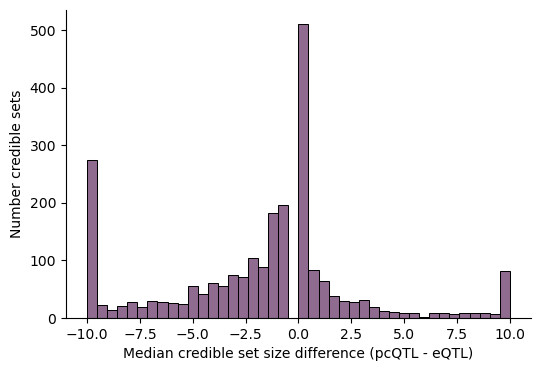

In [219]:
# just multigene signals
multigene_signals['size_diff'] = multigene_signals['median_pc_cs_size'] - multigene_signals['median_e_cs_size']
multigene_signals['size_diff'] = multigene_signals['size_diff'].clip(-10, 10)
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(multigene_signals, x='size_diff', bins = 42, ax=ax, alpha=.8,
             color='#734675')
             #hue='cs_size_label', palette={'eQTL':'#67AFD2','pcQTL':'#B83A4B', 'same size':'#734675'})
ax.set_xlabel('Median credible set size difference (pcQTL - eQTL)')
ax.set_ylabel('Number credible sets')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print(ttest_rel(multigene_signals['median_e_cs_size'], multigene_signals['median_pc_cs_size']))
print(ranksums(multigene_signals['median_e_cs_size'], multigene_signals['median_pc_cs_size']))

/local/scratch/klawren/slrmtmp.47304989/ipykernel_62763/1475561284.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 250)
/local/scratch/klawren/slrmtmp.47304989/ipykernel_62763/1475561284.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 250)


(0.7702672154735587, 250)

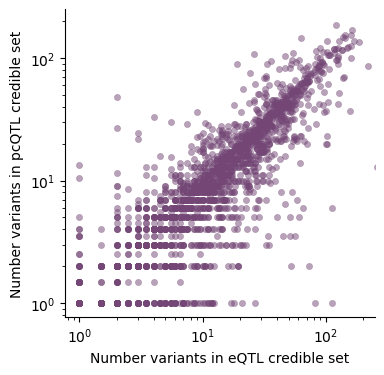

In [220]:
fig, ax = plt.subplots(figsize=(4,4))

sns.scatterplot(multigene_signals, x='median_e_cs_size', y='median_pc_cs_size',
                color='#734675', ax=ax, 
                edgecolor=None, s=20, alpha=.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Number variants in pcQTL credible set')
ax.set_xlabel('Number variants in eQTL credible set')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(0, 250)
ax.set_ylim(0, 250)